# Crustacean Age Prediction
Crustacean Age Prediction is a project that utilizes machine learning algorithms, such as Random Forest and XGBoost, to predict the age of crustaceans. By analyzing various features, including length, diameter, height, and weight, the models are trained to estimate the age accurately. The project includes data exploration, cleaning, feature engineering, modeling, and testing stages, providing insights into the dataset and evaluating the performance of the models. With its ability to predict crustacean age, this project contributes to understanding the growth patterns and characteristics of these marine creatures.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pickle

#sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

Reading Data

In [2]:
#Reading the dleaned dataset
file_path = 'data.csv'

df = pd.read_csv(file_path)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3894 entries, 0 to 3893
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             3894 non-null   object 
 1   Length          3894 non-null   float64
 2   Diameter        3894 non-null   float64
 3   Height          3894 non-null   float64
 4   Weight          3893 non-null   float64
 5   Shucked Weight  3894 non-null   float64
 6   Viscera Weight  3893 non-null   float64
 7   Shell Weight    3893 non-null   float64
 8   Age             3894 non-null   float64
dtypes: float64(8), object(1)
memory usage: 273.9+ KB


Data Exploration

In [4]:
# Show the basic statistics of the numerical features
df.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,3894.000000,3894.000000,3894.000000,3893.000000,3894.000000,3893.000000,3893.000000,3894.000000
mean,1.311415,1.020984,0.349403,23.567275,10.210581,5.136546,6.795844,9.954802
std,0.300470,0.248266,0.104978,13.891201,6.277724,3.104133,3.943392,3.220553
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524,1.000000
25%,1.125000,0.875000,0.287500,12.672227,5.343881,2.664853,3.713785,8.000000
50%,1.362500,1.062500,0.362500,22.792998,9.546694,4.861939,6.662132,10.000000
75%,1.537500,1.200000,0.412500,32.786197,14.273973,7.200773,9.355335,11.000000
max,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


There is an issue for Height feature, it should not be 0

There is one missing value

Skewness: 1.105
Kurtosis: 2.337
count    3894.000000
mean        9.954802
std         3.220553
min         1.000000
25%         8.000000
50%        10.000000
75%        11.000000
max        29.000000
Name: Age, dtype: float64


<ipython-input-5-b4561a11fc15>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Age'])


<Axes: xlabel='Age', ylabel='Density'>

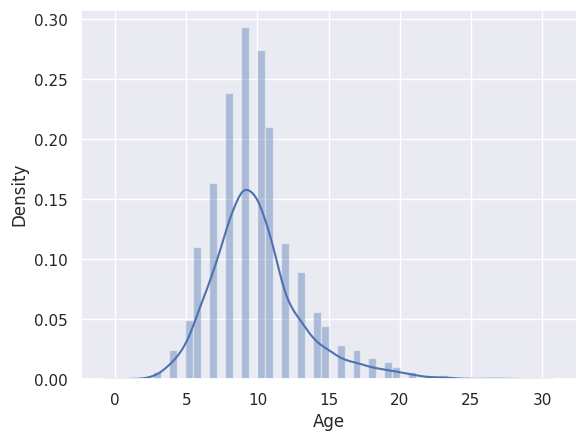

In [5]:
# checking the target variable: Age

print("Skewness: %.3f" % df['Age'].skew())
print("Kurtosis: %.3f" % df['Age'].kurt())

print(df['Age'].describe())
sns.distplot(df['Age'])

The target variable is ok, a bit skewed to the right

<Axes: >

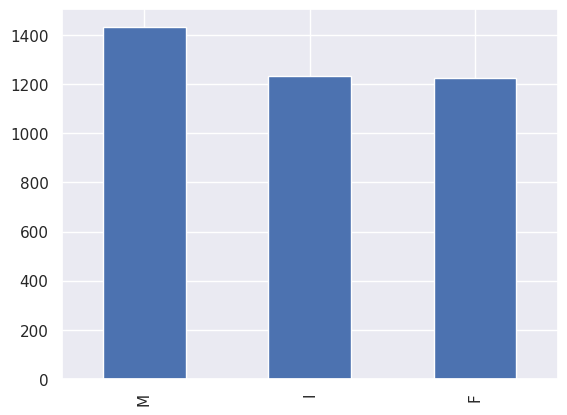

In [6]:
# Categorical feature:see any inbalance
df['Sex'].value_counts().plot.bar()

Seems pretty balance

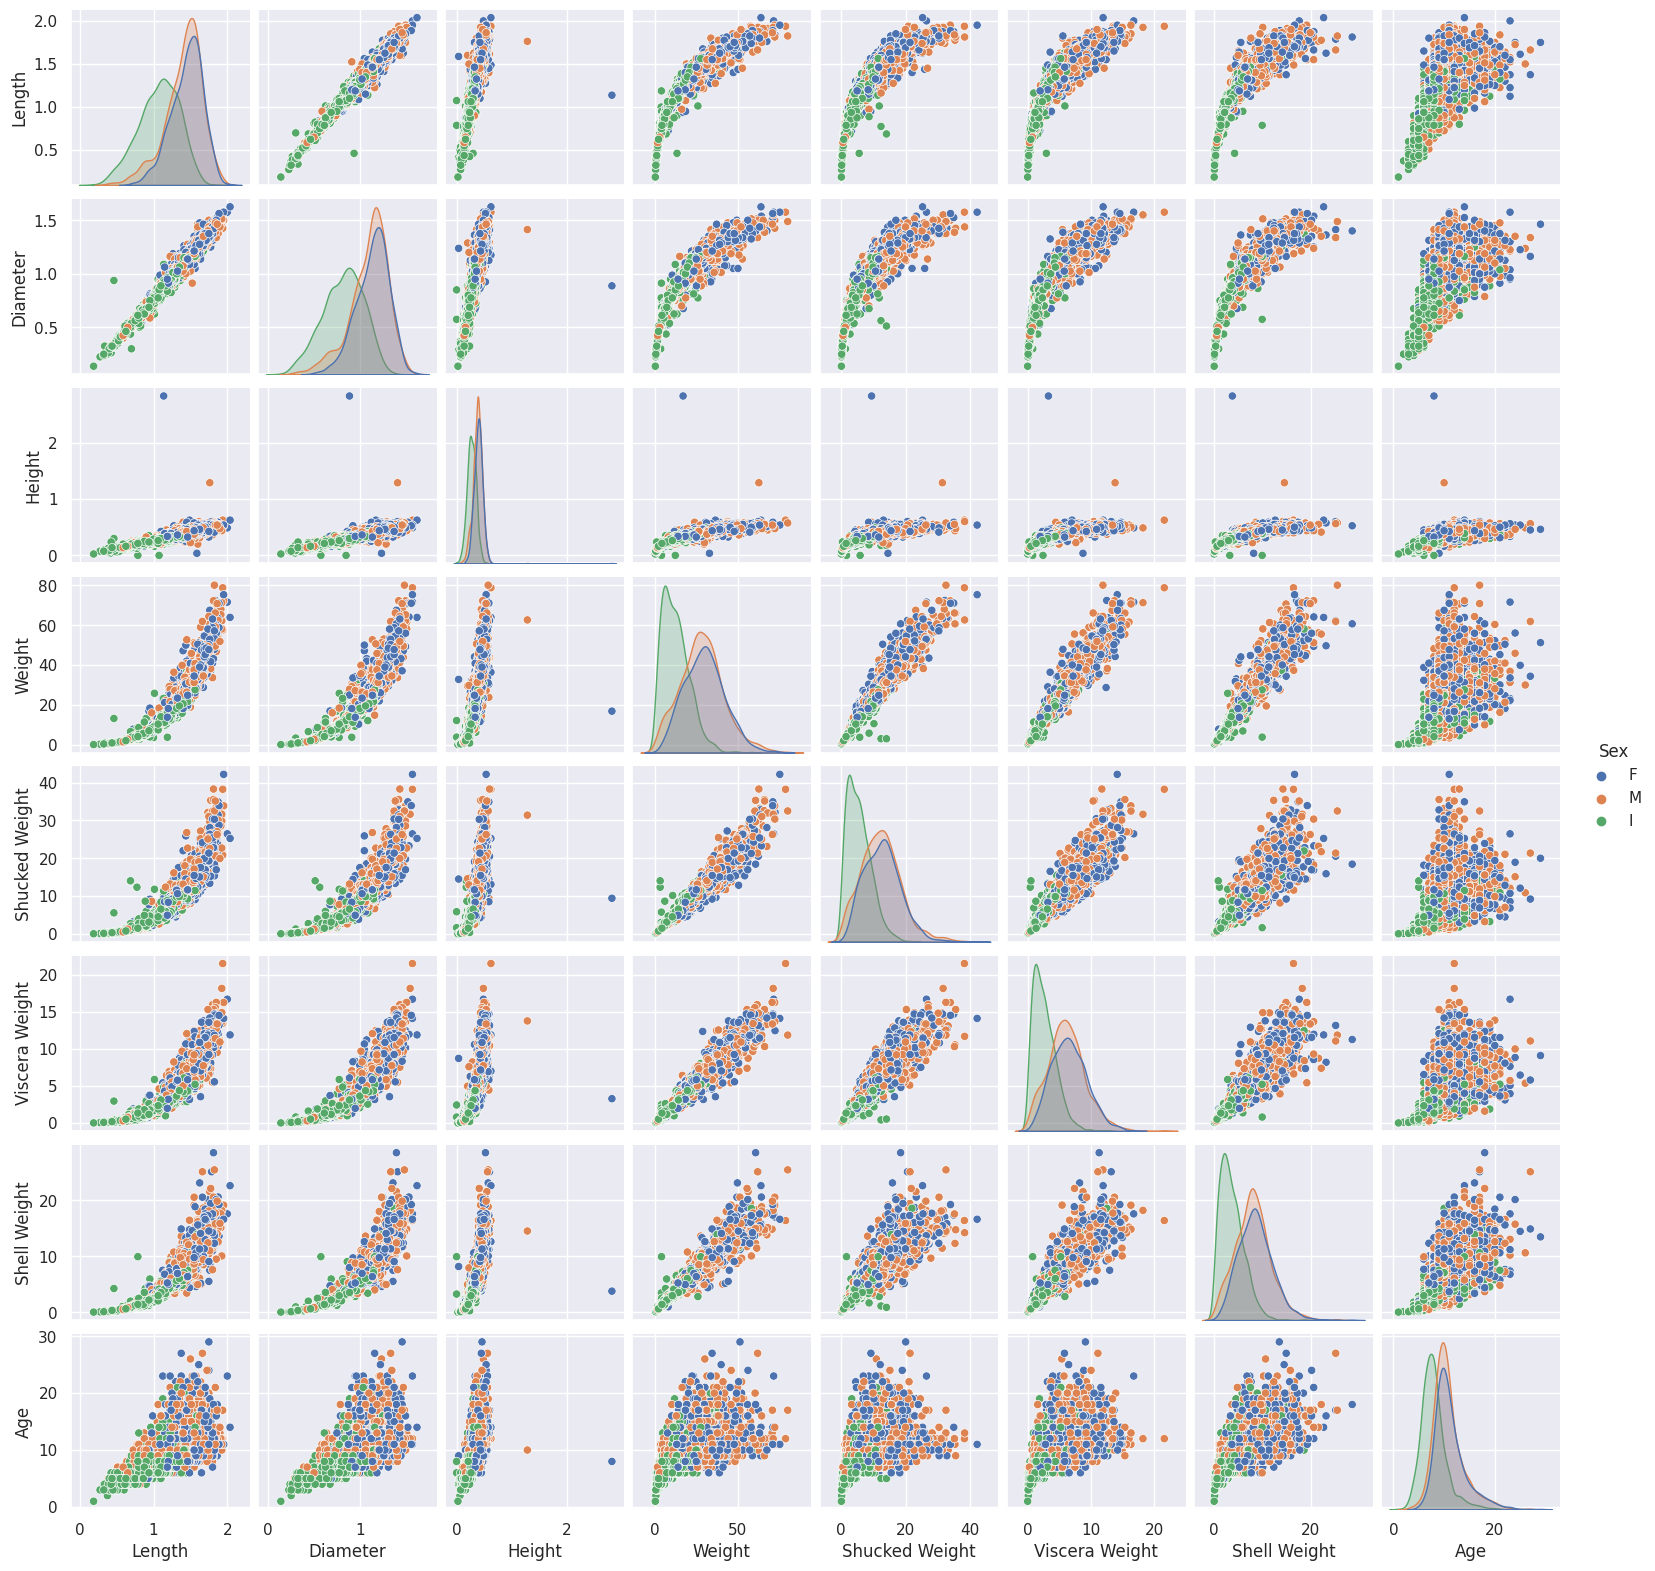

In [7]:
# Pair plot grouped by the only categorial variable
sns.pairplot(df, hue = 'Sex', height = 2)

The crustacean would be smaller and younger if the sex is I

It seems most of the features are highly correlated with others.

We can see there are several outliers in the data( Height), we should remove them

<Axes: xlabel='Age', ylabel='Height'>

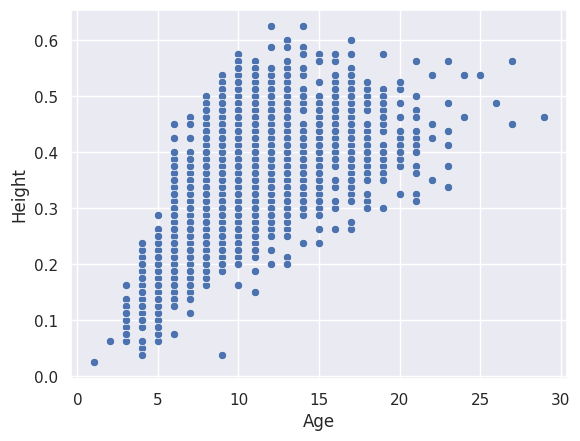

In [11]:
#From the scatter plot: it is better to remove Height > 1

sns.scatterplot(data=df, x='Age', y='Height')

#Data cleaning

<Axes: xlabel='Age', ylabel='Height'>

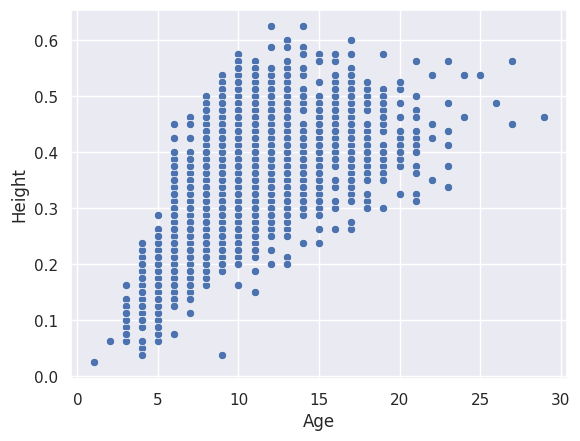

In [12]:
#drop outliers for Height <=0 and >1

df = df.query('Height >0 & Height <1')

#check if it look better
sns.scatterplot(x='Age', y='Height', data=df)

In [13]:
#as there is only one missing record, we can just drop it
df.dropna(inplace = True)

In [14]:

#One hot encode the categorial data
Sex_cat = pd.get_dummies(df['Sex'], prefix = 'Sex')

df = pd.concat([df,Sex_cat],axis = 1)
df.drop('Sex',axis = 1, inplace = True)

In [15]:
df.head()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Sex_F,Sex_I,Sex_M
0,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,9.0,1,0,0
1,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6.0,0,0,1
2,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,6.0,0,1,0
3,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,10.0,1,0,0
4,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,6.0,0,1,0


#Features Engineering

In [16]:
'''
The intuitive thinking would be the larger the volume the older it is so
we can create a feature called size which is Length * Diameter * Height
'''

df['Size'] = df['Length']*df['Diameter']*df['Height']

'''
We all have experienced that we eat a large crab but just little meat inside
so lets create three features called density which is weight/ size
density_shucked as scucked weight/ size
density_viscera as Viscera Weight/size
'''

df['Density'] = df['Weight']/df['Size']
df['Density_shucked'] = df['Shucked Weight']/df['Size']
df['Density_viscera'] = df['Viscera Weight'] /df['Size']

# lets see how much its weight without the shell
df['Weight_no_Shell'] = df['Weight'] - df['Shell Weight']

#Also the density without the shell
df['Density_no_shell'] = df['Weight_no_Shell']/df['Size']

In [17]:
df.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Sex_F,Sex_I,Sex_M,Size,Density,Density_shucked,Density_viscera,Weight_no_Shell,Density_no_shell
count,3889.000000,3889.000000,3889.000000,3889.000000,3889.000000,3889.000000,3889.000000,3889.000000,3889.000000,3889.000000,3889.000000,3889.000000,3889.000000,3889.000000,3889.000000,3889.000000,3889.000000
mean,1.311430,1.020985,0.348676,23.566978,10.205423,5.136603,6.794735,9.956801,0.314734,0.316534,0.368732,0.543229,44.618646,19.319918,9.746920,16.772243,31.532229
std,0.300344,0.248154,0.095736,13.878951,6.267387,3.101406,3.942452,3.221693,0.464470,0.465184,0.482523,0.325657,9.534930,6.513708,2.763640,10.176381,7.657793
min,0.187500,0.137500,0.025000,0.056699,0.028349,0.014175,0.042524,1.000000,0.000000,0.000000,0.000000,0.000645,13.761465,7.753709,3.716063,0.014175,0.889524
25%,1.125000,0.875000,0.287500,12.686401,5.343881,2.679028,3.713785,8.000000,0.000000,0.000000,0.000000,0.284883,40.319289,16.389993,8.408286,8.788345,27.822726
50%,1.362500,1.062500,0.362500,22.792998,9.553781,4.861939,6.662132,10.000000,0.000000,0.000000,0.000000,0.515625,43.692560,18.724401,9.475175,15.918244,30.859467
75%,1.537500,1.200000,0.412500,32.786197,14.273973,7.200773,9.355335,11.000000,1.000000,1.000000,1.000000,0.764285,47.578884,21.404843,10.676885,23.558435,34.250351
max,2.037500,1.625000,0.625000,80.101512,42.184056,21.545620,28.491248,29.000000,1.000000,1.000000,1.000000,2.069336,445.041829,227.586230,118.523894,62.411424,334.021883


#Split train and test set
Split the data into training and testing dataset for the model evaluation

In [18]:
#20% for testing
y = df['Age']
X = df.drop('Age',axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size = 0.2,
                                                    random_state = 123
                                                   )

#Modelling

**First trial: random forest regressor**

In [19]:
rf_grid_param = {
    'n_estimators': [200,300],
    'max_depth': [5,10,15,None],
    'min_samples_split': [0.01,0.02],
    'min_samples_leaf': [1, 2, 4]
}

rf_regressor = RandomForestRegressor(random_state= 123)

In [20]:
rf_GS = GridSearchCV(estimator=rf_regressor,
                     param_grid=rf_grid_param,
                     scoring= ['r2','neg_mean_squared_error','neg_mean_absolute_error'],
                     refit = 'neg_mean_squared_error',
                     cv = 5,
                     n_jobs = -1,
                     verbose = 2
                     )

In [21]:
rf_GS.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=123), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [0.01, 0.02],
                         'n_estimators': [200, 300]},
             refit='neg_mean_squared_error',
             scoring=['r2', 'neg_mean_squared_error',
                      'neg_mean_absolute_error'],
             verbose=2)

In [22]:
print(rf_GS.best_params_)
print(rf_GS.best_score_)

{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 0.01, 'n_estimators': 300}
-4.701110729684426


**Second try: XGBoost**

In [23]:
xgb_grid_param = {
    'n_estimators': [400,500],
    'max_depth': [5,10],
    'learning_rate': [0.01,0.02],
    'subsample': [0.9,1],
    'min_samples_leaf': [1, 2, 4]
}

xgb_regressor = xgb.XGBRegressor(eval_metric = 'rmse',n_jobs= -1,random_state=123)

In [24]:
xgb_GS = GridSearchCV(estimator=xgb_regressor,
                     param_grid=xgb_grid_param,
                     scoring= ['r2','neg_mean_squared_error','neg_mean_absolute_error'],
                     refit = 'neg_mean_squared_error',
                     cv = 5,
                     n_jobs = -1,
                     verbose = 8
                     )

In [25]:
xgb_GS.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[08:22:52] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_leaf" } are not used.



GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=-1, num_parallel_tree=None,
                                    predictor=None, random_state=123, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.02], 'max_depth': [5, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'n_estimators': [400, 500], 'subsample': [0.9, 1]},
             refit='neg_mean_squared_error',
             scoring=['r2', 'neg_mean_squared_error',
                      'neg_mean_absolute_error'],
             verbose=8)

In [26]:
print(xgb_GS.best_score_)
print(xgb_GS.best_params_)

-4.650091629472587
{'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 500, 'subsample': 0.9}


# Testing
tsting the result using final model

In [27]:
best_xgb = xgb.XGBRegressor(**xgb_GS.best_params_, eval_metric = 'rmse',n_jobs= -1, objective='reg:squarederror')
best_xgb.fit(X_train,y_train)
y_pred_xgb = best_xgb.predict(X_test)

best_rf = RandomForestRegressor(**rf_GS.best_params_)
best_rf.fit(X_train,y_train)
y_pred_rf = best_rf.predict(X_test)

[08:23:01] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_leaf" } are not used.



In [28]:
print ('Result using XGBoost Regressor:')
print("MSE: %.3f" % mean_squared_error(y_test,y_pred_xgb))
print("MSE: %.3f" % np.sqrt(mean_squared_error(y_test,y_pred_xgb)))
print("MAE: %.3f" % mean_absolute_error(y_test,y_pred_xgb))
print("R2: %.3f" % r2_score(y_test,y_pred_xgb))

print ('Result using Random Forest Regressor:')
print("MSE: %.3f" % mean_squared_error(y_test,y_pred_rf))
print("MSE: %.3f" % np.sqrt(mean_squared_error(y_test,y_pred_rf)))
print("MAE: %.3f" % mean_absolute_error(y_test,y_pred_rf))
print("R2: %.3f" % r2_score(y_test,y_pred_rf))



Result using XGBoost Regressor:
MSE: 4.261
MSE: 2.064
MAE: 1.437
R2: 0.565
Result using Random Forest Regressor:
MSE: 4.280
MSE: 2.069
MAE: 1.468
R2: 0.564


**Save the best model for the program**

In [29]:
pickle.dump(best_xgb, open('./best_xgb.dat', 'wb'))

**Checking ather stats**

<ipython-input-36-25a0a1963230>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test,color = 'blue',hist = False, label = 'Actual test data')
<ipython-input-36-25a0a1963230>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_xgb, color = 'red',hist = False,label = 'Pred

The summary stats of actual data: 
 count    778.000000
mean      10.044987
std        3.133541
min        4.000000
25%        8.000000
50%       10.000000
75%       11.000000
max       23.000000
Name: Age, dtype: float64

The summary stats of predicted data: 
 count    778.000000
mean       9.980338
std        2.393686
min        3.022226
25%        8.506507
50%        9.975063
75%       11.280350
max       19.244612
dtype: float64


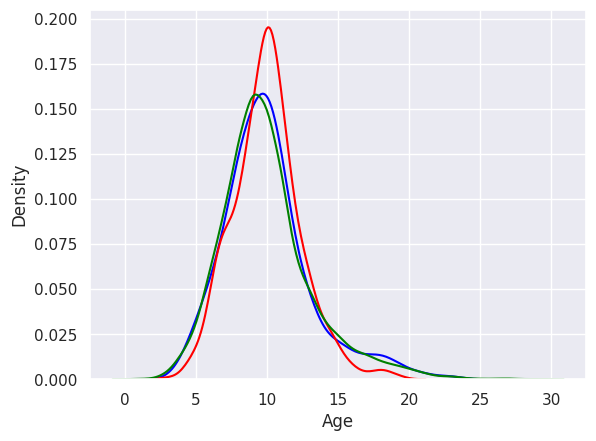

In [36]:
sns.distplot(y_test,color = 'blue',hist = False, label = 'Actual test data')
sns.distplot(y_pred_xgb, color = 'red',hist = False,label = 'Predicted')
sns.distplot(df['Age'],color = 'green',hist = False,label = 'All data')

print('The summary stats of actual data: \n',y_test.describe())

print('\nThe summary stats of predicted data: \n' ,pd.Series(y_pred_xgb).describe())

<Axes: title={'center': 'Feature importance (cover)'}, xlabel='F score', ylabel='Features'>

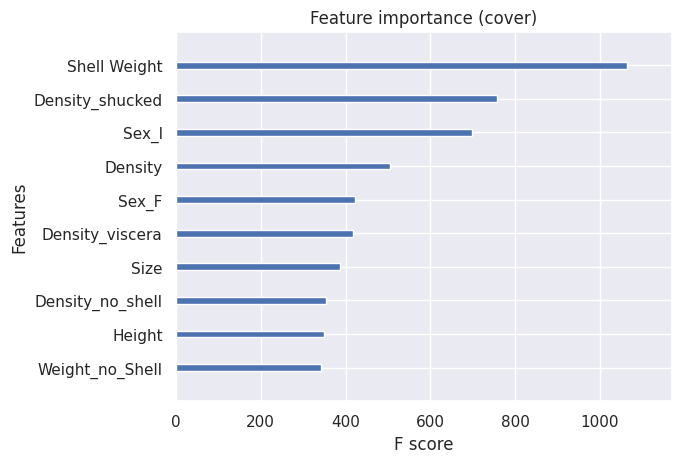

In [37]:
# find out which features are the most important

xgb.plot_importance(best_xgb,importance_type = 'cover',show_values= False ,title = 'Feature importance (cover)',max_num_features= 10)

**As the Shell Weight is the most important feature, lets see how it is distributed across age**

<Axes: xlabel='Age', ylabel='Size'>

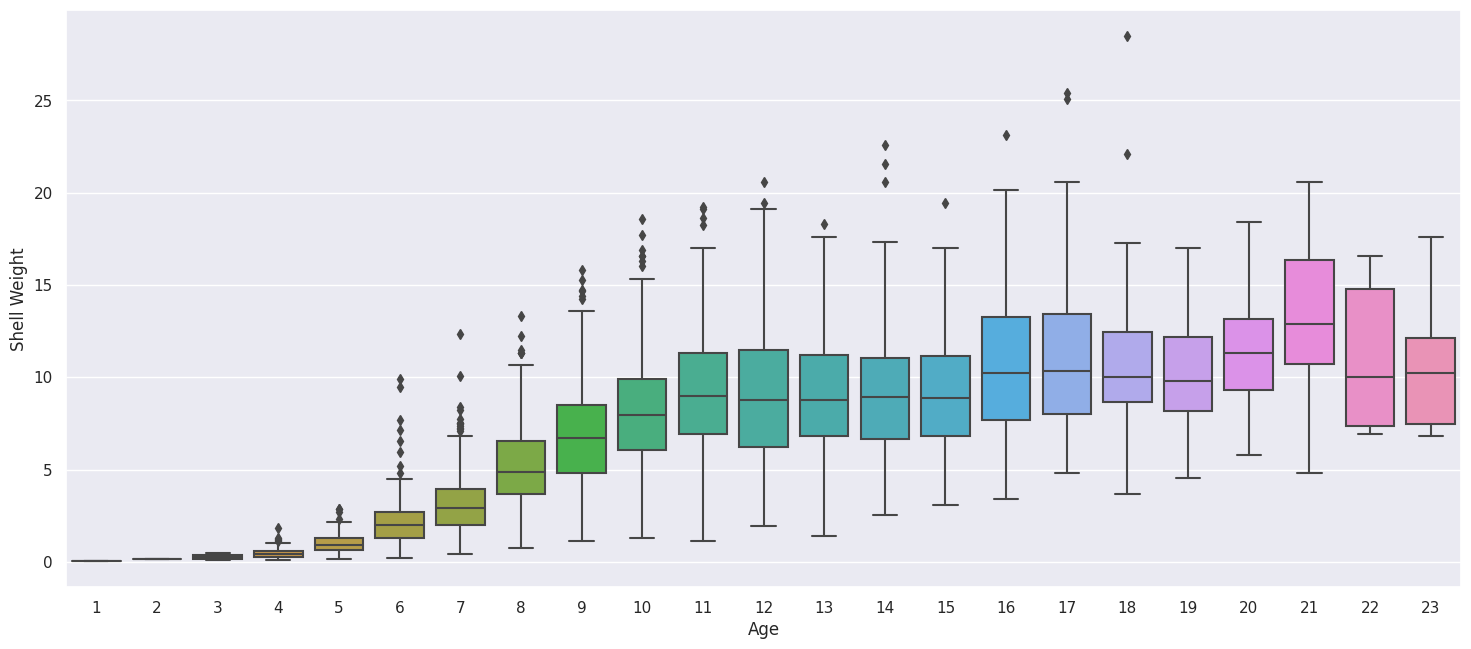

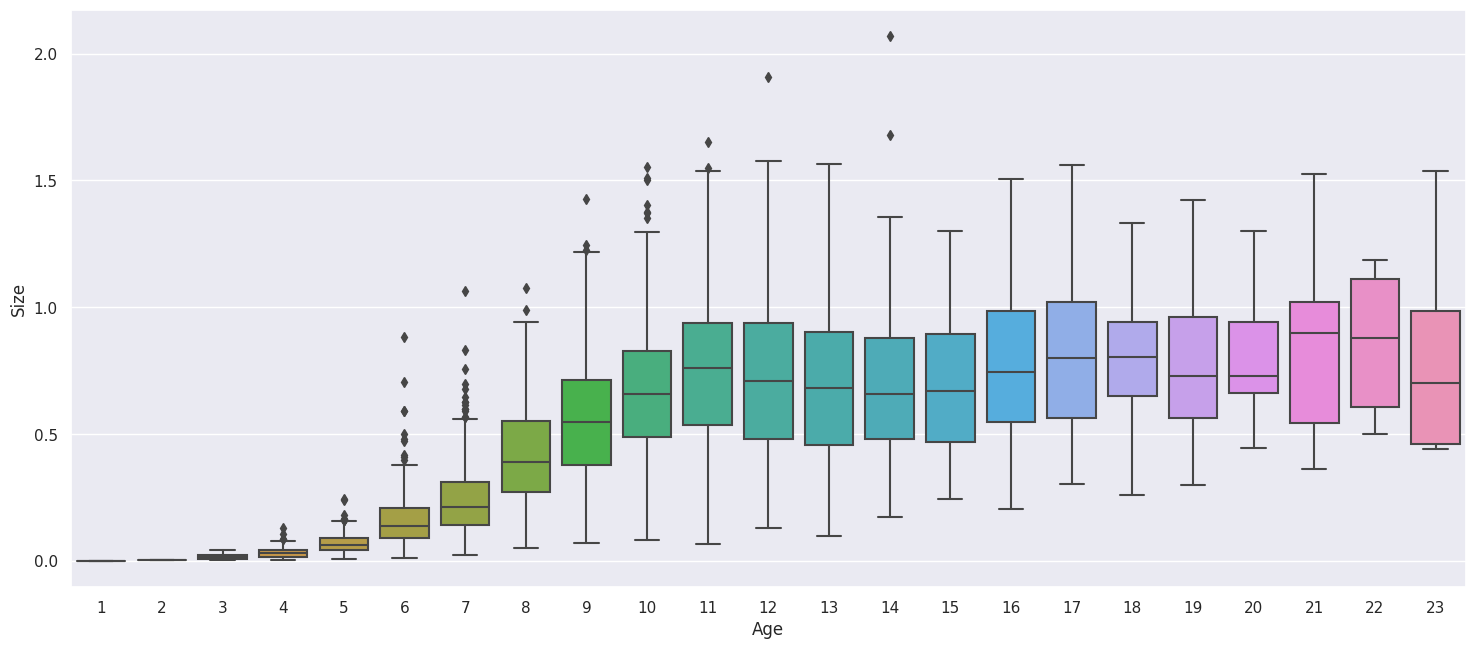

In [38]:
df['Age'] = df['Age'].astype(int)
fig, ax = plt.subplots(figsize=[18,7.5])
sns.boxplot( y = 'Shell Weight', x = 'Age',ax= ax, data = df.query('Age < 24'))
fig, ax2 = plt.subplots(figsize=[18,7.5])
sns.boxplot( y = 'Size', x = 'Age',ax= ax2, data = df.query('Age < 24'))

We can see the Shell weight and the size are about the same after age of 11